# Data cleaning and handling

In [1]:
#ICTRP Search: "covid-19" or "novel coronavirus" or "2019-ncov" or "covid19" or "sars-cov-2"
import xmltodict
import pandas as pd
import numpy as np
from datetime import date
import unicodedata

#POINT THIS TO THE UPDATED XML - deprecated as ICTRP is down.

#with open('ICTRP-Results_18Mar2020.xml', 'rb') as f:
#    xml = xmltodict.parse(f, dict_constructor=dict)

#df = pd.DataFrame(xml['Trials_downloaded_from_ICTRP']['Trial'])

#This now takes the CSV posted by the ICTRP as an input from here: https://www.who.int/ictrp/en/

df = pd.read_excel('this_weeks_data/covid-19-trials_25Mar2020.xlsx', dtype={'Phase': str})

#UPDATE THESE WITH EACH RUN
prior_extract_date = date(2020,3,18)
this_extract_date = date(2020,3,25)

In [2]:
#Taking only what we need right now

cols = ['TrialID', 'Source Register', 'Date registration', 'Date enrollement', 'Primary sponsor', 
        'Recruitment Status', 'Phase', 'Study type', 'Countries', 'Public title', 'Intervention',
        'web address', 'results url link', 'Last Refreshed on']

df_cond = df[cols].reset_index(drop=True)

#renaming columns to match old format so I don't have to change them throughout
df_cond.columns = ['TrialID', 'Source_Register', 'Date_registration', 'Date_enrollement', 
                   'Primary_sponsor', 'Recruitment_Status', 'Phase', 'Study_type', 'Countries', 
                   'Public_title', 'Intervention', 'web_address', 'results_url_link', 
                   'Last_Refreshed_on']

print(f'Search on ICTRP reveals {len(df_cond)} trials as of {this_extract_date}')

Search on ICTRP reveals 667 trials as of 2020-03-25


In [3]:
#POINT THIS TO LAST WEEK'S DATA
last_weeks_trials = pd.read_csv('last_weeks_data/trial_data_18_mar.csv')

In [4]:
#Joining in the 'first_seen' field
df_cond = df_cond.merge(last_weeks_trials[['trialid', 'first_seen']], left_on = 'TrialID', right_on = 'trialid', 
                        how='left').drop('trialid', axis=1)

#Adding the `first_seen` field to new trials
df_cond['first_seen'] = pd.to_datetime(df_cond['first_seen'].fillna(this_extract_date))

In [5]:
#Check for which registries we are dealing with:
df_cond.Source_Register.value_counts()

ChiCTR                             524
ClinicalTrials.gov                 121
IRCT                                 8
JPRN                                 5
EU Clinical Trials Register          3
TCTR                                 2
ISRCTN                               2
German Clinical Trials Register      1
Netherlands Trial Register           1
Name: Source_Register, dtype: int64

When working with data straight from XML we need to do some tedious tidying up of dates because of different formats. They do not parse correctly by default in Pandas. They are standardized, however, in the ICTRP spreadsheet so I have removed this code for now. It is archived in old commits to the GitHub repo for future refrence if needed.

In [6]:
#lets get rid of trials from before 2020 for now

pre_2020 = len(df_cond[df_cond['Date_registration'] < pd.Timestamp(2020,1,1)])

print(f'Excluded {pre_2020} trials from before 2020')

df_cond_rec = df_cond[df_cond['Date_registration'] >= pd.Timestamp(2020,1,1)].reset_index(drop=True)

print(f'{len(df_cond_rec)} trials remain')

Excluded 1 trials from before 2020
666 trials remain


This code removes trials that indicate that they never started. This is done on the Chinese registry through specific language in the Title. Trials from ClinicalTrials.gov are indicated by the `Withdrawn` trial status. 

This will be expanded moving forward to account for the unique terminology used by other registries as necessary moving forward.

In [7]:
#Removing cancelled/withdrawn trials for what registries we have to date

cancelled_trials = len(df_cond_rec[(df_cond_rec['Public_title'].str.contains('Cancelled')) | 
                                   (df_cond_rec['Public_title'].str.contains('Retracted due to')) | 
                                   (df_cond_rec['Recruitment_Status'] == "Withdrawn")])

print(f'Excluded {cancelled_trials} cancelled trials with no enrollment')

#Now lets get rid of trials we know don't belong from manual review, reason catalogued below
#NCT04226157 Non-COVID trial delayed because of COVID and put this in the title
#NCT04246242 This trial registration doesn't exist anymore

exclude = ['NCT04226157', 'NCT04246242']

print(f'Excluded {len(exclude)} non-COVID trials screened through manual review')

df_cond_nc = df_cond_rec[~((df_cond_rec['Public_title'].str.contains('Cancelled')) | 
                           (df_cond_rec['Public_title'].str.contains('Retracted due to'))) & 
                         ~(df_cond_rec['Recruitment_Status'] == "Withdrawn") &
                         ~(df_cond_rec['TrialID'].isin(exclude))].reset_index(drop=True)

print(f'{len(df_cond_nc)} trials remain')

Excluded 42 cancelled trials with no enrollment
Excluded 2 non-COVID trials screened through manual review
622 trials remain


Now we just need to take a quick look at trials that came and went since the last update. We can add in any additional trials that we know about that are not accounted for in the ICTRP database.

In [8]:
#Function for checking changes

def trial_diffs(new=True):
    df = df_cond_nc.merge(last_weeks_trials['trialid'], left_on = 'TrialID', right_on = 'trialid', how='outer', indicator=True)
    if new:
        new = df[(df['_merge'] == 'left_only')]
        return new['TrialID'].tolist()
    else:
        dropped = df[(df['_merge'] == 'right_only')]
        return dropped['trialid'].tolist()

In [9]:
print(f'There are {len(trial_diffs(new=True))} new trials')

print(f'The following trials were removed since the last time and were manually checked:')
print(trial_diffs(new=False))

There are 98 new trials
The following trials were removed since the last time and were manually checked:
['NCT04246242', 'ChiCTR2000030168', 'NCT04299152', 'ChiCTR2000030224', 'ChiCTR2000029759', 'NCT04280913', 'NCT04307459', 'NCT04290780', 'NCT04290858', 'NCT04303299', 'ChiCTR2000030704']


In [10]:
additions = pd.read_excel('manual_data.xlsx', sheet_name = 'additional_trials')

print(f'An additional {len(additions)} known trials were not in the ICTRP data')

print(set(additions['TrialID'].tolist()).difference(df_cond_nc['TrialID'].tolist()))

df_cond_nc = df_cond_nc.append(additions)

print(f'The final dataset is {len(df_cond_nc)} trials')

An additional 4 known trials were not in the ICTRP data
{'NCT04299152', 'NCT04303299', 'NCT04307459', 'NCT04290780'}
The final dataset is 626 trials


Normalisation and data cleaning of all fields. This will be expanded each update as more trials get added and more registries start to add trials with their own idiosyncratic data categories. 

In [11]:
#A small function to help quickly check the contents of various columns

def check_fields(field):
    return df_cond_nc[field].unique()

#Check fields for new unique values that require normalisation
check_fields('Study_type')

array(['Observational study', 'Interventional study', 'Diagnostic test',
       'Observational', 'Interventional', 'Basic Science', 'Prevention',
       'Prognosis study', 'Treatment study', 'Epidemilogical research',
       'Health services reaserch', 'Expanded Access', 'Screening',
       'Observational [Patient Registry]',
       'Interventional clinical trial of medicinal product',
       'interventional', 'observational'], dtype=object)

In [12]:
#Data cleaning various fields. 
#One important thing we have to do is make sure there are no nulls or else the data won't properly load onto the website

#Can't have nulls in the results field. Might need to move this later on when we start populating results
df_cond_nc['results_url_link'] = df_cond_nc['results_url_link'].fillna('No Results')

#semi-colons in the intervention field mess with CSV
df_cond_nc['Intervention'] = df_cond_nc['Intervention'].str.replace(';', '')

#phase
df_cond_nc['Phase'] = df_cond_nc['Phase'].fillna('Not Applicable')
phase_fixes = {'0':'Not Applicable', '1':'Phase 1', '2':'Phase 2', '3':'Phase 3', '4':'Phase 4', 
               '1-2':'Phase 1/Phase 2', 'Retrospective study':'Not Applicable', 
               'Not applicable':'Not Applicable',
               'New Treatment Measure Clinical Study':'Not Applicable', 
               '2020-02-01 00:00:00':'Phase 1/Phase 2',
               '2020-03-02 00:00:00':'Phase 2/Phase 3', 'Phase III':'Phase 3',
               'Human pharmacology (Phase I): no\nTherapeutic exploratory (Phase II): yes\nTherapeutic confirmatory - (Phase III): no\nTherapeutic use (Phase IV): no\n': 'Phase 2',
               'Human pharmacology (Phase I): no\nTherapeutic exploratory (Phase II): no\nTherapeutic confirmatory - (Phase III): yes\nTherapeutic use (Phase IV): no\n': 'Phase 3'
              }
df_cond_nc['Phase'] = df_cond_nc['Phase'].replace(phase_fixes)

#Study Type
obv_replace = ['Observational [Patient Registry]', 'observational']
int_replace = ['interventional', 'Interventional clinical trial of medicinal product', 'Treatment']

df_cond_nc['Study_type'] = df_cond_nc['Study_type'].str.replace(' study', '')
df_cond_nc['Study_type'] = df_cond_nc['Study_type'].replace(obv_replace, 'Observational')
df_cond_nc['Study_type'] = df_cond_nc['Study_type'].replace(int_replace, 'Interventional')
df_cond_nc['Study_type'] = df_cond_nc['Study_type'].replace('Epidemilogical research', 'Epidemiological research')
df_cond_nc['Study_type'] = df_cond_nc['Study_type'].replace('Health services reaserch', 'Health services research')

#Recruitment Status
df_cond_nc['Recruitment_Status'] = df_cond_nc['Recruitment_Status'].replace('Not recruiting', 'Not Recruiting')
df_cond_nc['Recruitment_Status'] = df_cond_nc['Recruitment_Status'].fillna('No Status Given')

#Get rid of messy accents

def norm_names(x):
    normed = unicodedata.normalize('NFKD', str(x)).encode('ASCII', 'ignore').decode()
    return normed 

df_cond_nc['Primary_sponsor'] = df_cond_nc.Primary_sponsor.apply(norm_names)
df_cond_nc['Primary_sponsor'] = df_cond_nc['Primary_sponsor'].replace('NA', 'No Sponsor Name Given')
df_cond_nc['Primary_sponsor'] = df_cond_nc['Primary_sponsor'].replace('nan', 'No Sponsor Name Given')

In [13]:
#Countries
df_cond_nc['Countries'] = df_cond_nc['Countries'].fillna('No Country Given')

china_corr = ['Chian', 'China?', 'Chinese', 'Wuhan', 'Chinaese', 'china']

country_values = df_cond_nc['Countries'].tolist()

new_list = []

for c in country_values:
    country_list = []
    if isinstance(c, float):
        country_list.append('No Sponsor Name Given')
    elif c == 'No Sponsor Name Given':
        country_list.append('No Sponsor Name Given')
    elif c in china_corr:
        country_list.append('China')
    elif c == 'Iran (Islamic Republic of)':
        country_list.append('Iran')
    elif c == 'Korea, Republic of':
        country_list.append('South Korea')
    elif c == 'Japan,Asia(except Japan),Australia,Europe':
        country_list = ['Japan', 'Australia', 'Asia', 'Europe']
    elif ';' in c:
        c_list = c.split(';')
        unique_values = list(set(c_list))
        for v in unique_values:
            if v == 'Iran (Islamic Republic of)':
                country_list.append('Iran')
            elif v == 'Korea, Republic of':
                country_list.append('South Korea')
            else:
                country_list.append(v)
    else:
        country_list.append(c)
    new_list.append(', '.join(country_list))

df_cond_nc['Countries'] = new_list

Last space for manual intervention. This will include manual normalisation of new names, any updates to the normalisation schedule from the last update, and updating manually-coded intervention type data.

In [14]:
#Normalizing sponsor names
#Run this cell, updating the spon_norm csv you are loading after manual adjusting
#until you get the 'All sponsor names normalized' to print

spon_norm = pd.read_excel('manual_data.xlsx', sheet_name = 'sponsor')

df_cond_norm = df_cond_nc.merge(spon_norm, left_on = 'Primary_sponsor', right_on ='unique_spon_names', how='left')
df_cond_norm = df_cond_norm.drop('unique_spon_names', axis=1)

new_unique_spon_names = (df_cond_norm[df_cond_norm['normed_spon_names'].isna()][['Primary_sponsor', 'TrialID']]
                        .groupby('Primary_sponsor').count())

if len(new_unique_spon_names) > 0:
    new_unique_spon_names.to_csv('to_norm.csv')
    print('Update the normalisation schedule and rerun')
else:
    print('All sponsor names normalized')

All sponsor names normalized


In [15]:
#Integrating intervention type data
#Once again, run to bring in the old int-type data, islolate the new ones, update, and rerun until
#producing the all-clear message

int_type = pd.read_excel('manual_data.xlsx', sheet_name = 'intervention')
df_cond_int = df_cond_norm.merge(int_type[['trial_id', 'intervention_type', 'intervention']], left_on = 'TrialID', right_on = 'trial_id', how='left')
df_cond_int = df_cond_int.drop('trial_id', axis=1)

new_int_trials = df_cond_int[(df_cond_int['intervention_type'].isna()) | (df_cond_int['intervention'].isna())]

if len(new_int_trials) > 0:
    new_int_trials[['TrialID', 'Public_title', 'Intervention', 'intervention_type', 'intervention']].to_csv('int_to_assess.csv')
    print('Update the intervention type assessments and rerun')
else:
    print('All intervention types matched')
    df_cond_int = df_cond_int.drop('Intervention', axis=1).reset_index(drop=True)

All intervention types matched


In [16]:
#Final organising

col_names = []

for col in list(df_cond_int.columns):
    col_names.append(col.lower())
    
df_cond_int.columns = col_names

reorder = ['trialid', 'source_register', 'date_registration', 'date_enrollement', 'normed_spon_names', 
           'recruitment_status', 'phase', 'study_type', 'countries', 'public_title', 'intervention_type', 'intervention',
           'web_address', 'results_url_link', 'last_refreshed_on', 'first_seen']

df_final = df_cond_int[reorder].reset_index(drop=True)

In [17]:
#Checking for any null values
df_final[df_final.isna().any(axis=1)]

,trialid,source_register,date_registration,date_enrollement,normed_spon_names,recruitment_status,phase,study_type,countries,public_title,intervention_type,intervention,web_address,results_url_link,last_refreshed_on,first_seen


In [20]:
#Quick look at the data
df_final.head()

,trialid,source_register,date_registration,date_enrollement,normed_spon_names,recruitment_status,phase,study_type,countries,public_title,intervention_type,intervention,web_address,results_url_link,last_refreshed_on,first_seen
0,ChiCTR2000029949,ChiCTR,2020-02-16,2020-02-16,Zhongnan Hospital of Wuhan University,Not Recruiting,Not Applicable,Observational,China,A Medical Records Based Study for the Effectiv...,Drug,Oxygen,http://www.chictr.org.cn/showproj.aspx?proj=49181,No Results,2020-02-17,2020-08-03
1,ChiCTR2000029953,ChiCTR,2020-02-17,2020-02-01,Zhongnan Hospital of Wuhan University,Not Recruiting,Not Applicable,Observational,China,Construction and Analysis of Prognostic Predic...,Prognosis,No Intervention,http://www.chictr.org.cn/showproj.aspx?proj=49217,No Results,2020-02-17,2020-08-03
2,ChiCTR2000029935,ChiCTR,2020-02-16,2020-02-06,"Hwa Mei Hospital, University of Chinese Academ...",Recruiting,Not Applicable,Interventional,China,A Single-arm Clinical Trial for Chloroquine Ph...,Drug,Chloroquine,http://www.chictr.org.cn/showproj.aspx?proj=49607,No Results,2020-02-17,2020-08-03
3,ChiCTR2000029947,ChiCTR,2020-02-16,2020-03-01,Longhua Hospital Affiliated to Shanghai Univer...,Not Recruiting,Not Applicable,Interventional,China,A Randomized Controlled Trial for Qingyi No. 4...,Traditional Medicine (Drug),Traditional Medicine,http://www.chictr.org.cn/showproj.aspx?proj=49599,No Results,2020-02-17,2020-03-18
4,ChiCTR2000029896,ChiCTR,2020-02-16,2020-01-31,Affiliated Hospital of Changchun University of...,Recruiting,Not Applicable,Observational,China,Evaluate the effectiveness of Traditional Chin...,Traditional Medicine (Unspecified),Traditional Medicine,http://www.chictr.org.cn/showproj.aspx?proj=49432,No Results,2020-02-17,2020-03-18


In [21]:
#Export final dataset
df_final.to_csv(f'processed_data_sets/trial_list_{this_extract_date}.csv')

In [24]:
#Export json for website
import json
with open("website_data/trials_latest.json", "w") as f:
    json.dump({"data": df_final.values.tolist()}, f, indent=2, default=str)

# Overall Trend in Registered Trials Graph

In [26]:
just_reg = df_final[['trialid', 'date_registration']].reset_index(drop=True)
#just_reg = mar18[['trialid', 'date_registration']].reset_index(drop=True)
#just_reg['date_registration'] = pd.to_datetime(just_reg['date_registration'], format='%d/%m/%Y')

#catch old registrations that were expanded to include COVID, we can get rid of these for now
just_reg = just_reg[just_reg['date_registration'] >= pd.Timestamp(2020,1,1)].reset_index(drop=True)


In [27]:
just_reg.index = just_reg['date_registration']


grouped = just_reg.resample('W').count()
cumsum = grouped.cumsum()

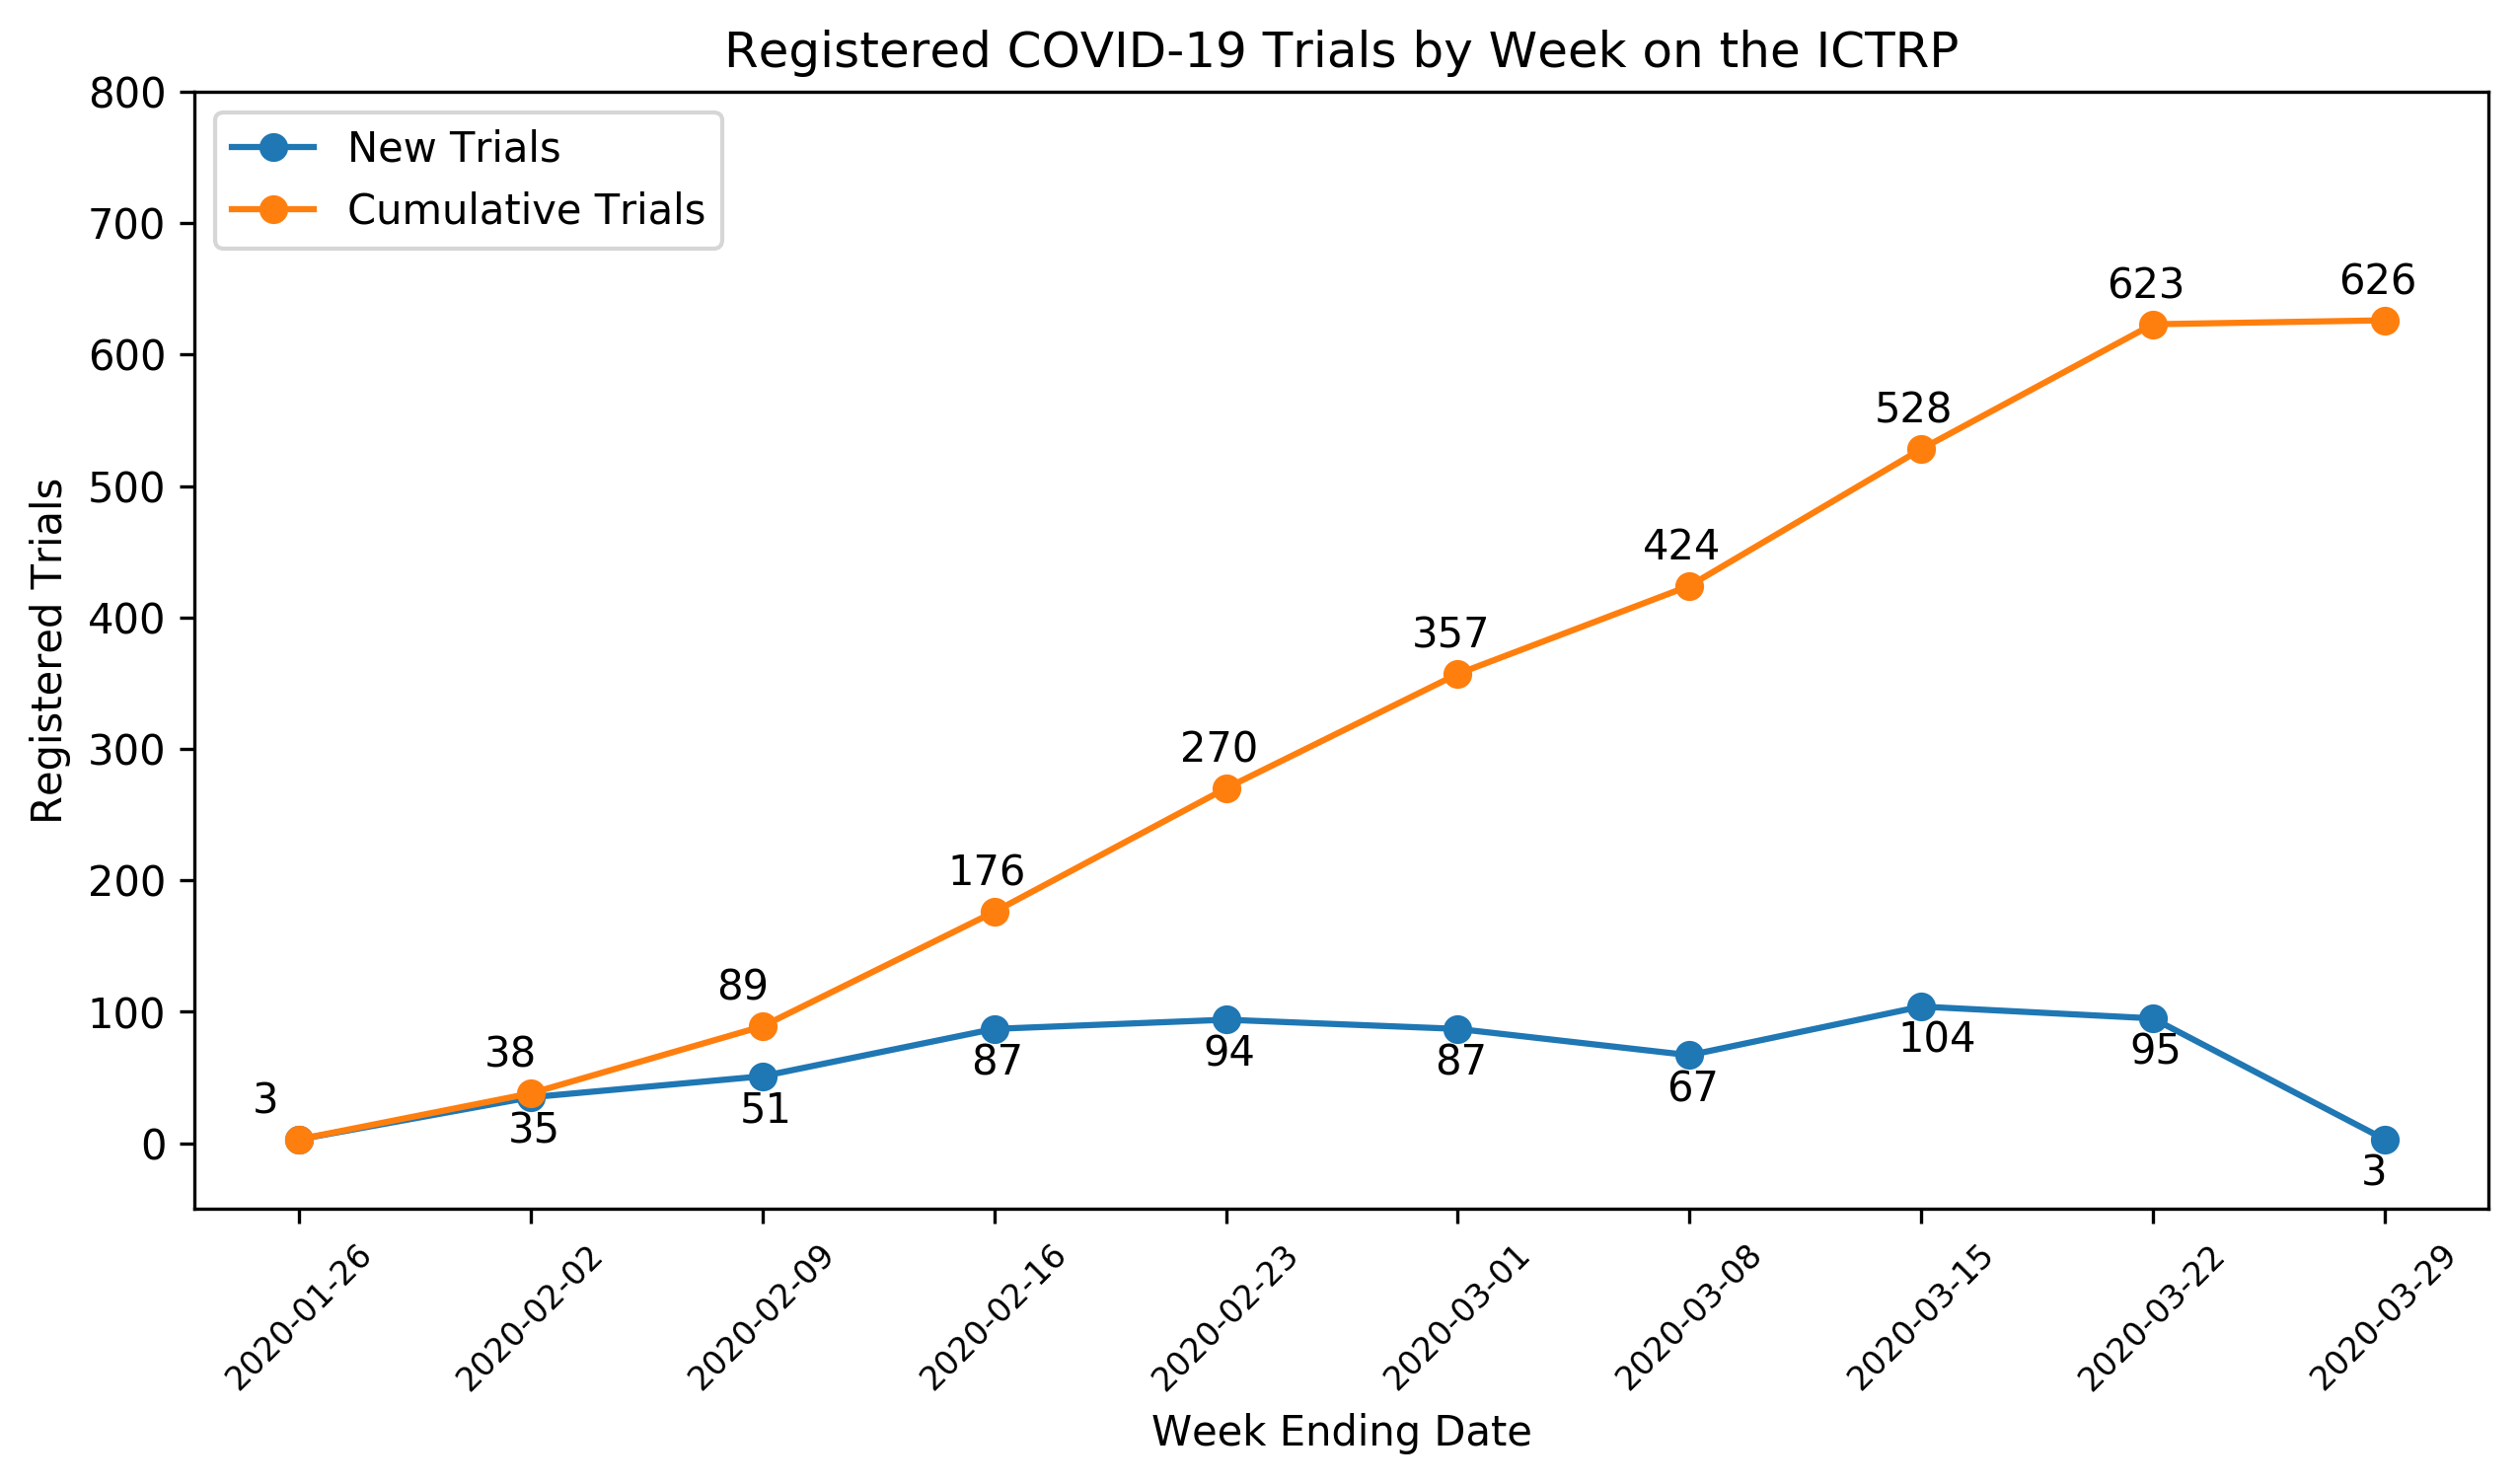

In [29]:
import matplotlib.pyplot as plt

labels = []

for x in list(grouped.index):
    labels.append(str(x.date()))

x_pos = [i for i, _ in enumerate(labels)]

fig, ax = plt.subplots(figsize=(10,5), dpi = 300)

l1 = plt.plot(x_pos, grouped['trialid'], marker = 'o')
l2 = plt.plot(x_pos, cumsum['trialid'], marker = 'o')

for i, j in zip(x_pos[1:], grouped['trialid'].tolist()[1:]):
    ax.annotate(str(j), (i,j), xytext = (i-.1, j-35))

for i, j in zip(x_pos, cumsum['trialid']):
    ax.annotate(str(j), (i,j), xytext = (i-.2, j+20))
    

gr = grouped['trialid'].to_list()
cs = cumsum['trialid'].to_list()

plt.xticks(x_pos, labels, rotation=45, fontsize=8)
plt.ylim(-50,800)
plt.xlabel('Week Ending Date')
plt.ylabel('Registered Trials')
plt.title('Registered COVID-19 Trials by Week on the ICTRP')
plt.legend(('New Trials', 'Cumulative Trials'), loc=2)
#plt.savefig(f'trial_count_{last_extract_date}.png')
plt.show()

In [31]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=labels, y=grouped['trialid'], fill=None, name='New Trials'))

fig.add_trace(go.Scatter(x=labels, y=cumsum['trialid'], fill=None, name='Cumulative Trials'))

fig.update_layout(title={'text': 'Registered COVID-19 Trials by Week', 'xanchor': 'center', 'x': 0.5}, 
                  xaxis_title='Week Ending Date',
                  yaxis_title='Registered Trials',
                  legend = dict(x=0, y=1, traceorder='normal', bgcolor='rgba(0,0,0,0)'))



fig.show()
#fig.write_html("registered trials.html")

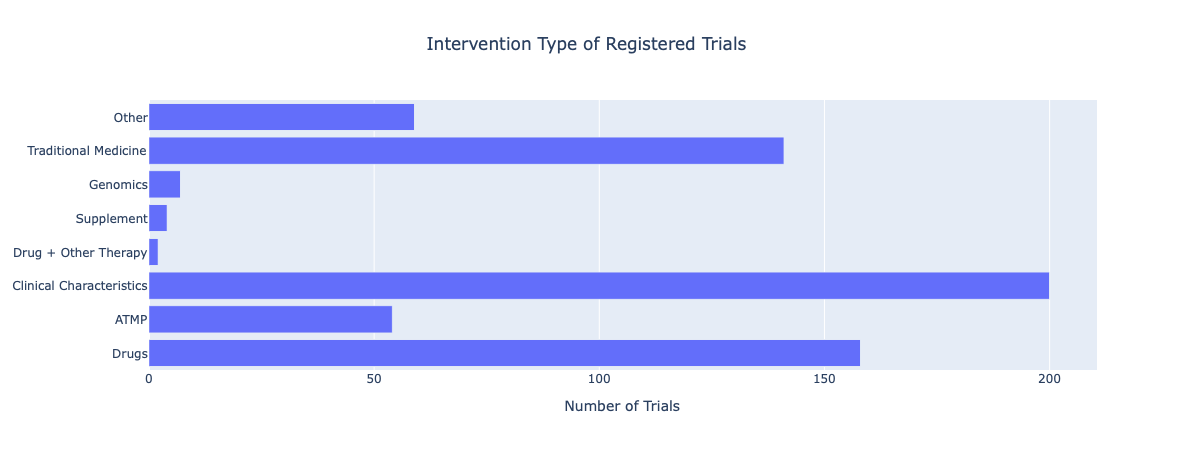

In [53]:
int_types = df_final.intervention_type.value_counts()

treatment_dict = dict(drugs = int_types['Drug'], 
                      atmp = int_types['ATMP'], 
                      clinical_char = int_types['Clinical Presentation'] + int_types['Diagnosis'] + int_types['Prognosis'],
                      drug_other_combo = int_types['Drug (+ATMP +Other (renal))'] + int_types['Drug (+ATMP)'],
                      supp = int_types['Supplement'],
                      geno = int_types['Genomics'],
                      tm = int_types[[s.startswith('Traditional Medicine') for s in int_types.index]].sum(),
                      other = int_types[[s.startswith('Other') for s in int_types.index]].sum()
                     )

fig = go.Figure(go.Bar(
            x=list(treatment_dict.values()),
            y=['Drugs', 'ATMP', 'Clinical Characteristics', 'Drug + Other Therapy', 'Supplement', 'Genomics', 'Traditional Medicine', 'Other'],
            orientation='h'))

fig.update_layout(title={'text': 'Intervention Type of Registered Trials', 'xanchor': 'center', 'x': 0.5}, 
                  xaxis_title='Number of Trials')

fig.show()
#fig.write_html('int_bar.html')